# Airline Passengers Example
This is a simple example that shows the basic flow of how to use AutoTS.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from AutoTS.AutoTS import AutoTS

### Import the data and do some light prep

This famous dataset comes from a statistics textbook from the 1960s, and it shows the monthly total
of international airline passengers from January 1949 to December 1960. To test our predictions,
we'll reserve the last 24 months as a test set

The AutoTS package requires that our dataset have a datetime index, so we'll also fix that

In [2]:
airline_data = pd.read_csv('AirPassengers.csv')
airline_data['Month'] = pd.to_datetime(airline_data['Month'])
airline_data = airline_data.set_index('Month')
airline_data_train, airline_data_test = airline_data[:120], airline_data[120:]

### Let's take a quick look at the data

There's a couple things to notice:
1. The series trends upward
2. The difference between the high points and low points increases over time
3. There's some obvious seasonality

The first two are ok, the models AutoTS uses will be able to account for those trends just fine. The
main thing to pay attention to is the period of the seasonality. When initializing the AutoTS model,
you can pass the argument `seasonal_period`, which should be the number of observations in each period.
Here, it's pretty clear we should use 12 (yearly seasonality). If it's not clear in your data, this is one
feature that is good to hypertune on your own.

<AxesSubplot:xlabel='Month'>

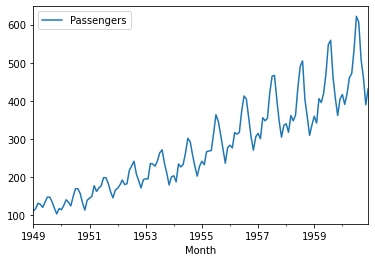

In [3]:
airline_data.plot()

### Training our model
By default, `AutoTS` tests four models, `auto_arima`, `exponential_smoothing`, and `tbats`, as well as
an ensemble of all three. If you like, you can specify a subset of those models using the `model_names`
argument. To determine model fit `AutoTS` uses [Mean Absolute Scaled Error](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error)

`AutoTS` roughly follows sklearn's `fit()`/`predict()`, paradigm. To fit the model, just provide it a pandas
dataframe and let it know the name of the column you'd like to predict using `series_column_name`.

In [4]:
model = AutoTS(seasonal_period=12)
model.fit(
    data=airline_data_train,
    series_column_name='Passengers'
          )

For the curious, there are a couple attributes about the model that can be accessed after fit

In [5]:
print(f'AutoTS found the best model for your data to be {model.fit_model_type}, with a '
      f'{model.error_metric} of {model.best_model_error:.2f}')

AutoTS found the best model for your data to be exponential_smoothing, with a mase of 0.16


### Let's make some predictions and plot them.

To predict, provide the model some datetimes. As long as the end date comes after the start date, you
can the model start the predictions from the beginning of the dataset it was trained on (for backtesting
purposes) all the way to one period after the end of the training dataset.

Since we split the data into a training and testing set at the beginning, we'll use the test set's
index to specify the start and end date.

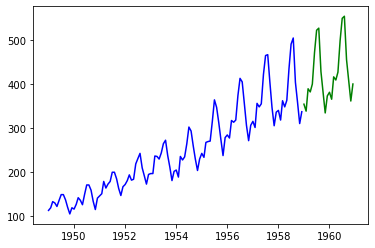

In [6]:
preds = model.predict(start_date=airline_data_test.index[0], end_date=airline_data.index[-1])

plt.plot(airline_data_train, c='blue')
plt.plot(preds, c='green')
plt.show()

Not bad! Comparing to the actuals, maybe it underpredicted a little bit, but it had a very good
MASE score and picked up well on the seasonality

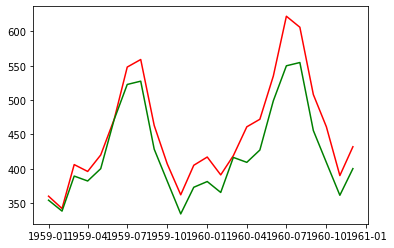

In [7]:
plt.plot(airline_data_test, c='red')
plt.plot(preds, c='green')
plt.show()

As an example of how important the seasonality parameter is, here's what the predictions would look
like if we assumed the data had bi-yearly seasonality.

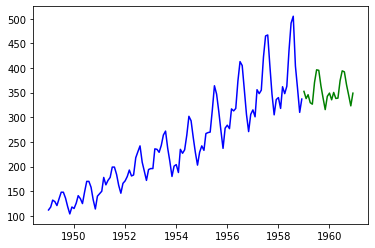

In [8]:
bad_model = AutoTS(seasonal_period=6)
bad_model.fit(
    data=airline_data_train,
    series_column_name='Passengers'
          )

bad_preds = bad_model.predict(start_date=airline_data_test.index[0], end_date=airline_data.index[-1])

plt.plot(airline_data_train, c='blue')
plt.plot(bad_preds, c='green')
plt.show()

Make sure to try a couple options out if you're not sure!

## Extra fine-tuning using extra model args

AutoTS tries to have sensible defaults, but maybe you want a little extra control over the models inside. If so, you can pass
extra specifications to the models using the `auto_arima_args`, `exponential_smoothing_args`,
and `tbats_args` arguments.

By default, pmdarima's `auto_arima()` uses [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)
as it's criterion for choosing between different ARIMA models. But what if you wanted to use [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion)?

You can pass a dictionary to `auto_arima_args` with this specification and AutoTS will forward that
on to `auto_arima()`. For example:

In [10]:
bic_model = AutoTS(auto_arima_args={'information_criterion': 'bic'})
bic_model.fit(data=airline_data_train, series_column_name='Passengers')

How do you know which extra arguments you pass? You'll have to do a little research to see what knobs and dials
each of the internal models allows. You can find a link to each of the model classes here:
- [auto_arima](https://github.com/alkaline-ml/pmdarima/blob/master/pmdarima/arima/auto.py#L347)
- [exponential_smoothing](https://github.com/statsmodels/statsmodels/blob/160911ace8119eefe0e66998ea56d24e590fc415/statsmodels/tsa/holtwinters.py#L449)
- [tbats](https://github.com/intive-DataScience/tbats/blob/master/tbats/bats/BATS.py#L5)

For example, if you click on the tbats link, you can see this code if you :

```python
class BATS(Estimator):
    def __init__(self,
                 use_box_cox=None, box_cox_bounds=(0, 1),
                 use_trend=None, use_damped_trend=None,
                 seasonal_periods=None, use_arma_errors=True,
                 show_warnings=True,
                 n_jobs=None, multiprocessing_start_method='spawn',
                 context=None):
```

The arguments defined in the `__init__()` function are ones you can specify through AutoTS. This would
be a valid arg dictionary:
```python
model = AutoTS(tbats_args={'use_box_cox': True})
```